In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import re

Import de données

In [2]:
CAC40_txt = """Accor SA (AC.PA)
L'Air Liquide S.A. (AI.PA)
Airbus SE (AIR.PA)
ArcelorMittal S.A. (MT.AS)
AXA SA (CS.PA)
BNP Paribas SA (BNP.PA)
Bouygues SA (EN.PA)
Bureau Veritas SA (BVI.PA)
Capgemini SE (CAP.PA)
Carrefour SA (CA.PA)
Crédit Agricole S.A. (ACA.PA)
Danone S.A. (BN.PA)
Dassault Systèmes SE (DSY.PA)
Edenred SE (EDEN.PA)
Engie SA (ENGI.PA)
EssilorLuxottica Société anonyme (EL.PA)
Eurofins Scientific SE (ERF.PA)
Hermès International (RMS.PA)
Kering SA (KER.PA)
Legrand SA (LR.PA)
L'Oréal S.A. (OR.PA)
LVMH (MC.PA)
Michelin (ML.PA)
Orange S.A. (ORA.PA)
Pernod Ricard SA (RI.PA)
Publicis Groupe S.A. (PUB.PA)
Renault SA (RNO.PA)
Safran SA (SAF.PA)
Compagnie de Saint-Gobain S.A. (SGO.PA)
Sanofi (SAN.PA)
Schneider Electric S.E. (SU.PA)
Société Générale (GLE.PA)
Stellantis N.V. (STLAP.PA)
STMicroelectronics N.V. (STMPA.PA)
Teleperformance SE (TEP.PA)
Thales S.A. (HO.PA)
TotalEnergies SE (TTE.PA)
Unibail-Rodamco-Westfield SE (URW.PA)
Veolia Environnement SA (VIE.PA)
Vinci SA (DG.PA)"""

tickers_CAC40 = re.findall(r'\(([^)]+)\)', CAC40_txt)

In [3]:
histo_CAC40 = yf.download(tickers = tickers_CAC40, start = '2015-01-01',end = '2025-02-01')["Close"]
histo_CAC40_maille1h =  yf.download(tickers = tickers_CAC40, start = '2024-01-01',end = '2025-02-01', interval='1h')["Close"]

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed


In [4]:
print(histo_CAC40.shape)
histo_CAC40["TEP.PA"].head(10)

(2583, 40)


Date
2015-01-02    48.126026
2015-01-05    47.900635
2015-01-06    47.124264
2015-01-07    47.216095
2015-01-08    48.142715
2015-01-09    47.666882
2015-01-12    49.920834
2015-01-13    50.104488
2015-01-14    49.879097
2015-01-15    50.588673
Name: TEP.PA, dtype: float64

Data cleaning

In [5]:
nan_par_colonne = {col: histo_CAC40.index[histo_CAC40[col].isna()].tolist() for col in histo_CAC40.columns}
for col in histo_CAC40.columns:
    taille_liste = len(nan_par_colonne[col])
    print(col, len(nan_par_colonne[col])) if taille_liste > 0 else next
    #print(col, len(nan_par_colonne[col]), nan_par_colonne[col]) if taille_liste > 0 else next


MT.AS 1
URW.PA 2122


In [6]:
histo_CAC40_sans_MT_URW = histo_CAC40.drop(columns=["URW.PA", "MT.AS"])
print(int(histo_CAC40_sans_MT_URW.isna().sum().sum()))
print(histo_CAC40_sans_MT_URW.shape)

0
(2583, 38)


Calcul des rendements, volatilités et corrélations

In [7]:
data = histo_CAC40_sans_MT_URW
# Calcul du vecteur de rendement moyen annuel
mu_annuel = np.log((data.iloc[-1, :]/data.iloc[0,:])) / (data.index[-1] - data.index[0]).days * 365.25

print("Rendements annuels :")
print(mu_annuel.head())

Rendements annuels :
Ticker
AC.PA     0.042511
ACA.PA    0.088683
AI.PA     0.112176
AIR.PA    0.151292
BN.PA     0.052707
dtype: float64


In [8]:
delta_année = data.index.to_series().diff().dt.days.iloc[1:] / 365.25
deltat_r = pd.DataFrame(delta_année.values[:, None] * mu_annuel.values, columns=mu_annuel.index, index=delta_année.index)
nb_jour_pan = data.shape[0] / (data.index[-1] - data.index[0]).days * 365.25
Volatilite_annuel = np.sqrt((np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).var() * nb_jour_pan)
mat_correlation = (np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).corr()

print("\nVolatilités :")
print(Volatilite_annuel.head())


Volatilités :
Ticker
AC.PA     0.319046
ACA.PA    0.309398
AI.PA     0.206439
AIR.PA    0.351973
BN.PA     0.194999
dtype: float64


In [9]:
print("\nMatrice de correlation :")
print(mat_correlation.iloc[ :7, :7])


Matrice de correlation :
Ticker     AC.PA    ACA.PA     AI.PA    AIR.PA     BN.PA    BNP.PA    BVI.PA
Ticker                                                                      
AC.PA   1.000000  0.585502  0.428098  0.634105  0.354309  0.602450  0.451828
ACA.PA  0.585502  1.000000  0.480506  0.558192  0.339130  0.853126  0.470121
AI.PA   0.428098  0.480506  1.000000  0.484603  0.499491  0.499644  0.519341
AIR.PA  0.634105  0.558192  0.484603  1.000000  0.373528  0.591485  0.465776
BN.PA   0.354309  0.339130  0.499491  0.373528  1.000000  0.367019  0.406833
BNP.PA  0.602450  0.853126  0.499644  0.591485  0.367019  1.000000  0.471934
BVI.PA  0.451828  0.470121  0.519341  0.465776  0.406833  0.471934  1.000000


In [59]:
#On travaille à la maille journalière
data = histo_CAC40_sans_MT_URW
log_return_jounalier_histo = np.log(data/data.shift(1))
log_return_jounalier_histo.iloc[0, :] = 0
log_return_jounalier_histo.head()

Ticker,AC.PA,ACA.PA,AI.PA,AIR.PA,BN.PA,BNP.PA,BVI.PA,CA.PA,CAP.PA,CS.PA,...,RNO.PA,SAF.PA,SAN.PA,SGO.PA,STLAP.PA,STMPA.PA,SU.PA,TEP.PA,TTE.PA,VIE.PA
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-05,-0.012959,-0.046957,-0.031456,0.003006,-0.025956,-0.049772,-0.045848,-0.049668,-0.013396,-0.037881,...,-0.035515,-0.001961,-0.029187,-0.044038,0.0,-0.015053,-0.044512,-0.004694,-0.061713,-0.025169
2015-01-06,-0.021146,-0.019418,-0.008380,0.022905,-0.003053,-0.026501,-0.007134,-0.007995,-0.039369,-0.010935,...,-0.005203,0.006846,0.003270,-0.016026,0.0,-0.010822,0.001394,-0.016341,-0.001502,-0.014065
2015-01-07,0.004983,-0.014318,0.004505,0.025714,0.011592,-0.016844,0.002003,-0.001057,0.004199,0.010663,...,-0.002263,0.016625,0.010555,-0.002722,0.0,0.020720,0.006250,0.001947,0.022417,0.007760
2015-01-08,0.019824,0.024074,0.041231,0.033509,0.028496,0.031905,0.024281,0.044461,0.028064,0.040506,...,0.037960,0.029469,0.041269,0.039628,0.0,0.032879,0.040365,0.019435,0.037854,0.018452


Text(0.5, 1.0, 'Evolution de la stratégie buy and hold (historique)')

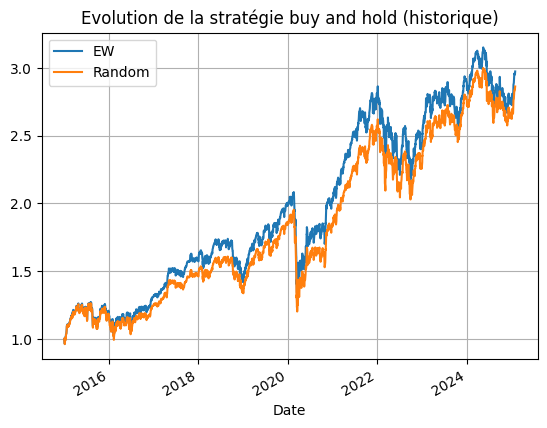

In [ ]:
nb_stocks = log_return_jounalier_histo.shape[1]

allocations_EW = np.ones(nb_stocks) / nb_stocks
allocations_random = np.random.rand(nb_stocks)
allocations_random /= allocations_random.sum()

#evolution stratégie buy and hold
evolution_EW_buyandHold  = np.exp(np.cumsum(log_return_jounalier_histo)) * allocations_EW
evolution_random_buyandHold = np.exp(np.cumsum(log_return_jounalier_histo)) * allocations_random

evolution_EW_buyandHold.sum(axis=1).plot(label="EW buy and hold")
evolution_random_buyandHold.sum(axis=1).plot(label="Random buy and hold")
plt.legend()
plt.grid()
plt.title("Evolution de la stratégie buy and hold (historique)")

Text(0.5, 1.0, 'Evolution de la stratégie rebalancée tous les 5 jours (historique)')

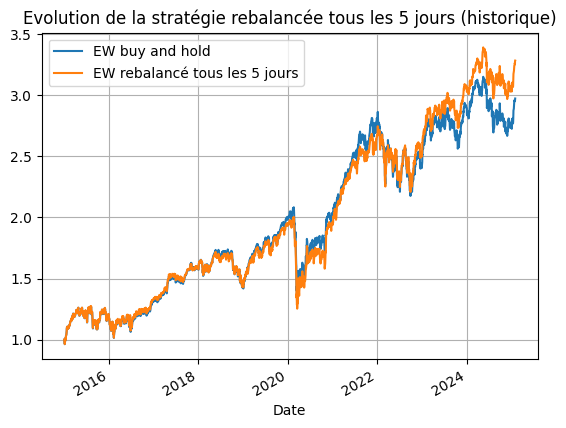

In [85]:
#strategie rebalancement tous les T jours
T = 5 # on rebalance tous les T jours 

evolution_EW_rebalancement5j = log_return_jounalier_histo * 0.0
evolution_EW_rebalancement5j.iloc[0, :] = allocations_EW
evolution_EW_rebalancement5j.iloc[0:T, :] = np.exp(np.cumsum(log_return_jounalier_histo.iloc[0:T, :])) * evolution_EW_rebalancement5j.iloc[0, :]
last_period = 0
for i in range(T, log_return_jounalier_histo.shape[0], T):
    evolution_EW_rebalancement5j.iloc[i, :] = evolution_EW_rebalancement5j.iloc[i-1, :].sum() * allocations_EW
    evolution_EW_rebalancement5j.iloc[i:i+T, :] = np.exp(np.cumsum(log_return_jounalier_histo.iloc[i:i+T, :])) * evolution_EW_rebalancement5j.iloc[i, :]
    last_period = i
evolution_EW_rebalancement5j.iloc[last_period:, :] = np.exp(np.cumsum(log_return_jounalier_histo.iloc[last_period:, :])) * evolution_EW_rebalancement5j.iloc[last_period-1, :]

evolution_EW_buyandHold.sum(axis=1).plot(label="EW buy and hold")
evolution_EW_rebalancement5j.sum(axis=1).plot(label="EW rebalancé tous les 5 jours")
plt.legend()
plt.grid()
plt.title("Evolution de la stratégie rebalancée tous les 5 jours (historique)")

In [83]:
evolution_EW_buyandHold.iloc[-1, :] - evolution_EW_rebalancement5j.iloc[-1, :]

Ticker
AC.PA      -9.714451e-17
ACA.PA     -8.326673e-17
AI.PA      -2.636780e-16
AIR.PA     -6.938894e-17
BN.PA      -2.220446e-16
BNP.PA     -1.249001e-16
BVI.PA      2.775558e-16
CA.PA       9.714451e-17
CAP.PA     -3.885781e-16
CS.PA       1.249001e-16
DG.PA      -2.914335e-16
DSY.PA      2.775558e-16
EDEN.PA     8.326673e-17
EL.PA      -2.775558e-17
EN.PA       0.000000e+00
ENGI.PA    -1.387779e-17
ERF.PA     -2.775558e-16
GLE.PA      9.020562e-17
HO.PA      -4.857226e-16
KER.PA      1.873501e-16
LR.PA      -8.326673e-17
MC.PA      -7.216450e-16
ML.PA      -1.249001e-16
OR.PA      -1.249001e-16
ORA.PA     -1.040834e-16
PUB.PA     -2.359224e-16
RI.PA      -1.665335e-16
RMS.PA      2.775558e-16
RNO.PA     -3.122502e-17
SAF.PA     -5.273559e-16
SAN.PA      1.110223e-16
SGO.PA     -5.551115e-17
STLAP.PA   -1.804112e-16
STMPA.PA   -4.857226e-16
SU.PA       2.775558e-17
TEP.PA     -1.804112e-16
TTE.PA     -1.387779e-16
VIE.PA      2.359224e-16
Name: 2025-01-31 00:00:00, dtype: float64